/usr/people/mihajlov/python/clipc/clipccombine
CLIPC dispel4py running
SETTING NAME: Collector
SETTING NAME: Match
SETTING NAME: Writer
SETTING NAME: Visualiser
SETTING NAME: SimpleFunctionPE
SETTING NAME: SimpleFunctionPE
SETTING NAME: SimpleProcessingPE
{'input': [('example/vDTR_JUN_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_EUR-11_2006-2100.nc', 'example/vDTR_OCT_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_EUR-11_2006-2100.nc')]}
in collector  example/vDTR_JUN_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_EUR-11_2006-2100.nc
in collector  example/vDTR_OCT_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_EUR-11_2006-2100.nc
in preprocess nc is      <type 'netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    description: Tier 1: vDTR. Multi-year period of records.
    keywords: CLIP-C,Tier 1,vDTR,rcp85,SMHI-RCA4
    activity: CLIP-C project
    method: CLIVAR panel ETCCDI
    software: ICCLIM 3.0.1 library
    software_platform: Python 2.7 on x86_64 GNU/Linux
    

{}

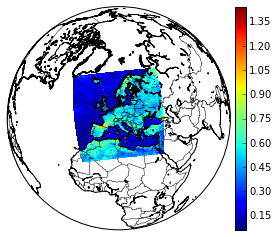

In [1]:
%matplotlib inline


from dispel4py.workflow_graph import WorkflowGraph 
from dispel4py.provenance import *
import time
import random
from dispel4py.base import create_iterative_chain, ConsumerPE, IterativePE, SimpleFunctionPE
from clipc_combine_process import clipc_combine_process_d4p
from clipc_combine_process import serve_netcdf_d4p

import matplotlib.pyplot as plt


# project: CLIP_C
# authors: Alessandro and Andrej
# CLIPC combine function using dispel4py and running over jupyter
# [mihajlov@pc150396 ~]$ .local/bin/jupyter-notebook 

#print __dir__

print "/usr/people/mihajlov/python/clipc/clipccombine"
print "CLIPC dispel4py running"

class Collector(GenericPE):

    def __init__(self):
        #IterativePE.__init__(self)
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('output_R')
        #self._add_output('output_W')
        
    
    def _process(self,inputs):
        print inputs
        
        url1,url2 = inputs['input'][0]
            
        nc1 = clipc_combine_process_d4p.collect(url1)
        self.write('output_R',nc1)
   
        nc2 = clipc_combine_process_d4p.collect(url2)
        self.write('output_R',nc2)
      
        nc_out = clipc_combine_process_d4p.write(nc1 , "output.nc" , "dr drej n spinuso rock the data flow.")
        
        self.log(type(nc_out))
        
        self.write('output_W',nc_out)
        
        
              
    
# def readn(data):
#     prov={'format':'Random float', 'metadata':{'value':str(data)}}
#     return {'_d4p_prov':prov,'_d4p_data':data}
        
        
# def multn(data): 
#     prov={'format':'Random float', 'metadata':{'value':data*data}}
#     print data
#     return {'_d4p_prov':prov,'_d4p_data':data*data}

    
def reader(nc):
    #nc = clipc_combine_process_d4p.collect(url)
    var , norm = clipc_combine_process_d4p.read(nc)

    return (var , norm)


##################################

class Match(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        #self._add_input('input2')
        self._accumulator = []
        self._add_output('output_X')
        
    
    def _process(self,inputs):
        print inputs
        
        #url1,url2 = inputs['input'][0]
        self._accumulator.append(inputs['input'])
        #self._accumulator.append(inputs['input2'])
        
        
        if( len(self._accumulator) == 2 ):
            #combine(self._accumulator)
            self.write('output_X',self._accumulator)

        #nc1 = clipc_combine_process_d4p.collect(url1)
        #self.write('output_R',nc1)
   
        #nc_out = clipc_combine_process_d4p.write(nc1 , "output.nc" , "dr drej n spinuso rock the data flow.")
        #self.write('output_W',nc_out)
        
        #nc2 = clipc_combine_process_d4p.collect(url2)
        #self.write('output_R',nc2)
        
def combine(data,operator):
    comb_var = clipc_combine_process_d4p.combine(data[0][0] , data[0][1] , data[1][0] , data[1][1] , operator)
    
    return comb_var


    
class Writer(GenericPE):

    def __init__(self,op):
        GenericPE.__init__(self)
        self._add_input('file')
        self._add_input('var')
        self._opp = op
        self._accumulator = []
        self._add_output('final')
        self.file=None
        self.var=None
        
    
    def _process(self,inputs):
        self.log(str(inputs))
      
        
        if 'file' in inputs:
            self.file=inputs['file']
        elif 'var' in inputs:
            self.var=inputs['var']   
            self.log(type(self.var))
            
        
        if (self.var!=None and self.file!=None):
            x=clipc_combine_process_d4p.postprocess(self.var,self.file)
            self.write('final',x[0])
            
            
class Visualiser(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        #self._accumulator = []
        #self.plot
    
    def _process(self,inputs):
        print inputs
        
        #self._accumulator.append(inputs['input'])
        fig = plt.figure(1)
        
        serve_netcdf_d4p.visualise1(fig, inputs['input']  )
        
        
    
###################################




sc1 = Collector()
sc1.name = 'collector'

sc2 = Match()
sc2.name = 'match'

sc3 = Writer("+")
sc3.name = 'writer'

sc4 = Visualiser()
sc4.name = 'vizu'

read=SimpleFunctionPE(reader)
comb=SimpleFunctionPE(combine,{"operator":"+"})
 

#processes=[readn,multn]
#chain = create_iterative_chain(processes, FunctionPE_class=SimpleFunctionPE)

#Initialise the graph
graph = WorkflowGraph()

#Common way of composing the graph
graph.connect(sc1,'output_R',read,'input')
graph.connect(read,'output', sc2,'input')
graph.connect(sc2,'output_X',comb,'input')
graph.connect(comb,'output',sc3,'var')
graph.connect(sc1,'output_W',sc3,'file')
graph.connect(sc3,'final',sc4,'input')

# Alternatively with pipeline array
#Create pipelines from functions

#graph.connect(sc,'output',chain,'input')



graph.flatten()


# /usr/people/mihajlov/python/clipc/clipccombine/clipc_combine_process
# file running: combine_netcdf.py
# def combine_two_indecies(url1,url2,operation,output,...):


#Prepare Input
url1 = 'example/vDTR_JUN_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_EUR-11_2006-2100.nc'
url2 = 'example/vDTR_OCT_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_EUR-11_2006-2100.nc'

input_data = {"collector": [{"input": [(url1,url2)] }]}

#Launch in simple process
simple_process.process_and_return(graph, input_data)

#plt.show()



In [2]:
%matplotlib inline


ProvenanceRecorderToServiceBulk.REPOS_URL='http://verce-portal-dev.scai.fraunhofer.de/j2ep-1.0/prov/workflow/insert'
rid='RDWD_'+getUniqueId()
InitiateNewRun(graph,ProvenanceRecorderToServiceBulk,provImpClass=ProvenancePE,username='aspinuso',runId=rid,w3c_prov=False,workflowName="test_rdwd",workflowId="xx")

simple_process.process_and_return(graph, input_data)

#plt.show()
#from IPython.display import HTML
#HTML("<iframe src='http://127.0.01:8080/provenance-explorer/html/d3js.jsp?level=PE&runId="+rid+"' width=800 height=800></iframe>")

SETTING NAME: NewWorkflowRun
SETTING NAME: ProvenanceRecorderToServiceBulk
Inputs: {'NewWorkflowRun': [{'input': 'None'}]}
SETTING NAME: SimpleProcessingPE
RUN Metadata: {'username': 'aspinuso', 'workflowId': 'xx', 'description': '', 'mapping': '-f', 'system_id': None, 'runId': 'RDWD_pc150396.knmi.nl-20717-94cce1fe-cf34-11e5-9f58-901b0e877023', 'startTime': '2016-02-09 13:54:04.637845', 'input': [], '_id': 'RDWD_pc150396.knmi.nl-20717-94cce1fe-cf34-11e5-9f58-901b0e877023', 'type': 'workflow_run', 'workflowName': 'test_rdwd'}
ProvenanceRecorderToServiceBulk7: Postprocress: (200, 'OK', <httplib.HTTPResponse instance at 0x7fdfdae94290>, '{"inserts": ["RDWD_pc150396.knmi.nl-20717-94cce1fe-cf34-11e5-9f58-901b0e877023"], "success": true}')
SimplePE: Processed 1 iteration.
Outputs: {}
Injecting provenance to: PE_combine Original type: (<class 'dispel4py.base.IterativePE'>,)
Injecting provenance to: PE_combine Transoformed: <class 'dispel4py.provenance.<class 'dispel4py.base.SimpleFunctionPE'>

{'collector0': {'error': [{'TriggeredByProcessIterationID': 'collector-pc150396.knmi.nl-20717-9562f5d6-cf34-11e5-9f58-901b0e877023',
    '_d4p': {'error': 'null'},
    'id': 'pc150396.knmi.nl-20717-9562f77a-cf34-11e5-9f58-901b0e877023'}]},
 'match2': {None: [{'TriggeredByProcessIterationID': 'match-pc150396.knmi.nl-20717-9576bbfc-cf34-11e5-9f58-901b0e877023',
    '_d4p': <dispel4py.provenance.<class '__main__.Match'> at 0x7fdfdb3ef710>,
    'id': 'pc150396.knmi.nl-20717-9576bdb4-cf34-11e5-9f58-901b0e877023'},
   {'TriggeredByProcessIterationID': 'match-pc150396.knmi.nl-20717-95779310-cf34-11e5-9f58-901b0e877023',
    '_d4p': <dispel4py.provenance.<class '__main__.Match'> at 0x7fdfdb3ef710>,
    'id': 'pc150396.knmi.nl-20717-95779554-cf34-11e5-9f58-901b0e877023'}]}}

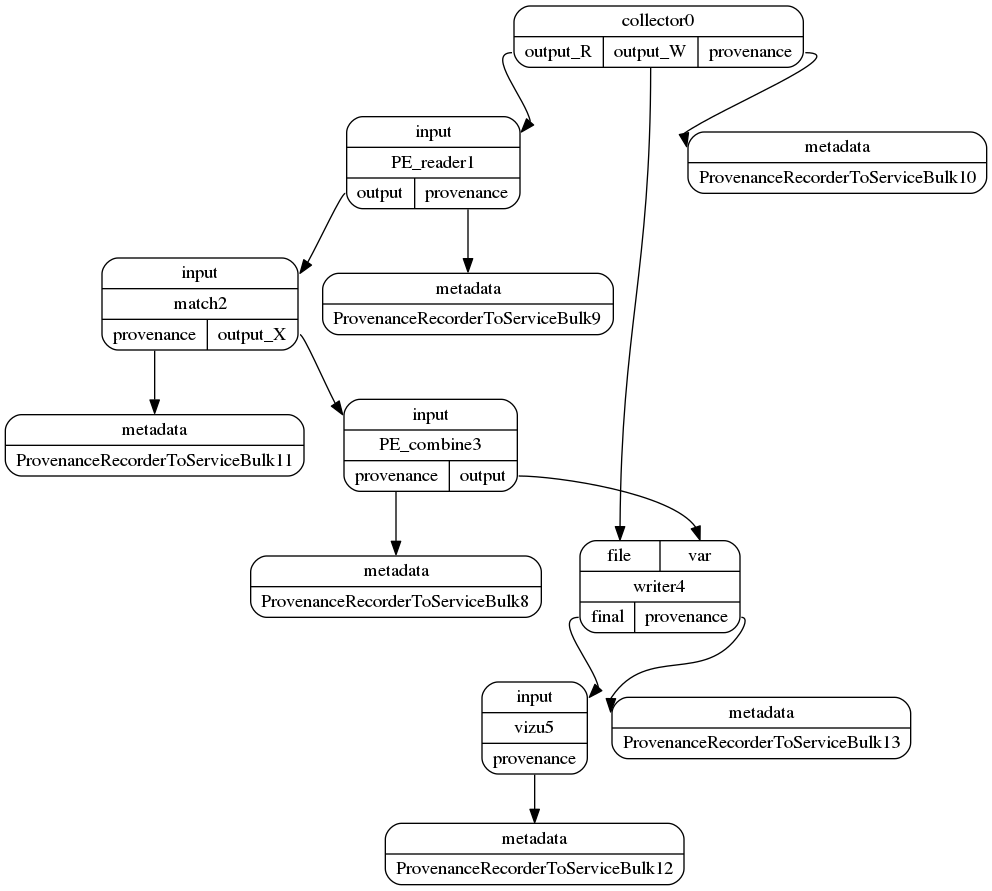

In [3]:
from dispel4py.visualisation import display

display(graph)

In [4]:

ProvenanceRecorderToServiceBulk.REPOS_URL='http://verce-portal-dev.scai.fraunhofer.de/j2ep-1.0/prov/workflow/insert'
rid='RDWD_'+getUniqueId()
#InitiateNewRun(graph,ProvenanceRecorderToServiceBulk,provImpClass=ProvenancePE,username='aspinuso',runId=rid,w3c_prov=False,workflowName="test_rdwd",workflowId="xx")

extra_args=['-n', '3']
dispel4py.new.processor.process_and_return(graph, input_data, 'multi',extra_args)



#from IPython.display import HTML
#HTML("<iframe src='http://127.0.01:8080/provenance-explorer/html/d3js.jsp?level=instances&runId="+rid+"' width=800 height=800></iframe>")

Graph is larger than job size: 12 > 3.


RuntimeError: NetCDF: Not a valid ID

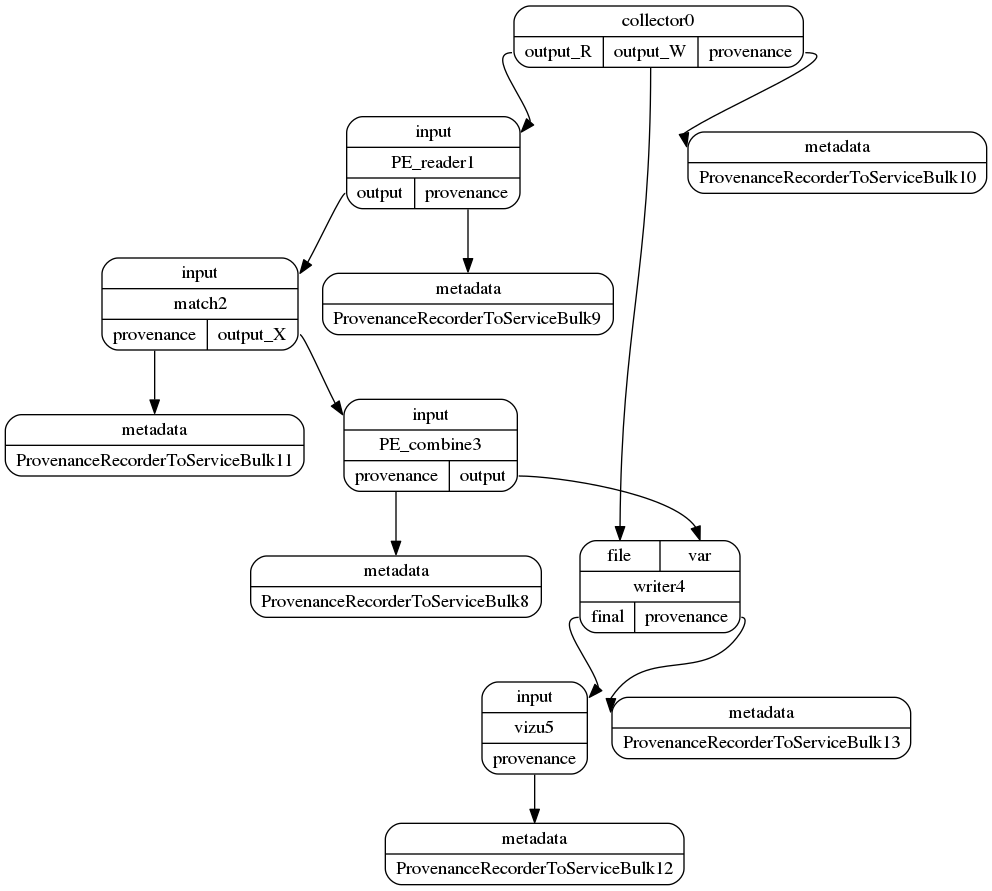

In [5]:
from dispel4py.visualisation import display

display(graph)